In [5]:
!pip3 install opencv-python

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/Library/

In [2]:
import os
import time
import uuid
import cv2


In [3]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [173]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


: 

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2022-11-29 19:51:09.594039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle = False) #For Windows, do "\\" instead of /

2022-11-29 19:51:15.492909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [ ]:
images.as_numpy_iterator().next()

b'data/images/5c3f8e68-7036-11ed-930b-3e22fb7d61b8.jpg'

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x) #Takes in file path and returns a byte encoded image
    img = tf.io.decode_jpeg(byte_img) #parses through the byte image
    return img

In [ ]:
images = images.map(load_image) #Applies the load image function to each file in the dataset

In [8]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [9]:
image_generator = images.batch(4).as_numpy_iterator() #Batches images up. Rather than returning 1 image, it will return the number of values inside of a batch

NameError: name 'images' is not defined

In [10]:
plot_images = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_images' is not defined

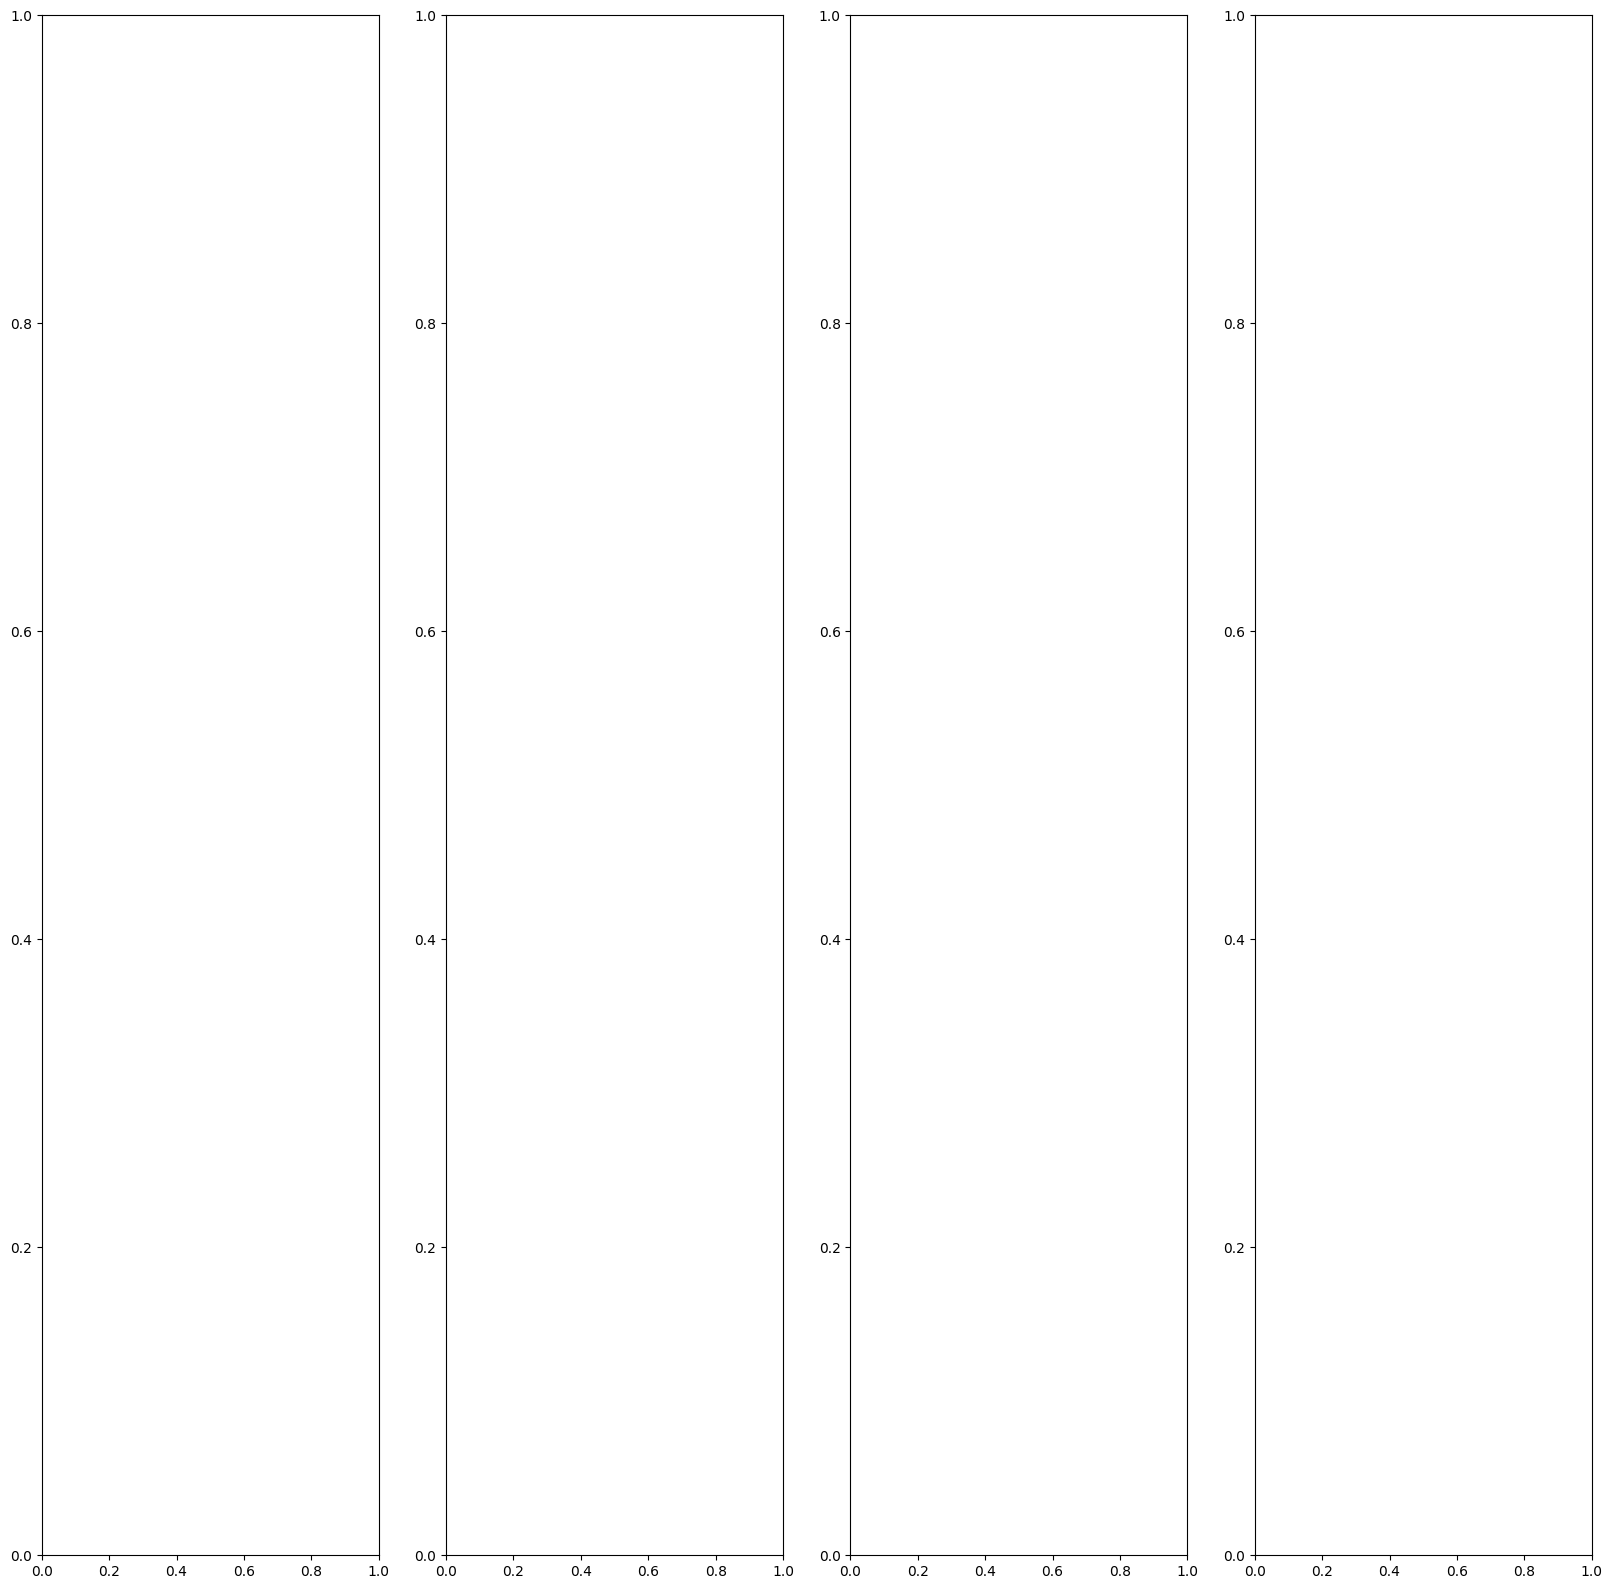

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

Partitioning Unaugmented Data
Send 70% to train folder and 15% to test and val

In [12]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
#Moves the labels fromthe raw folder to their corresponding images

In [13]:
import albumentations as alb

In [14]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450), 
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2), 
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [15]:
img = cv2.imread(os.path.join('data', 'train', 'images', '7f3bab18-7036-11ed-930b-3e22fb7d61b8.jpg'))

In [16]:
img.shape

(720, 1280, 3)

In [17]:
with open(os.path.join('data', 'train', 'labels', '7f3bab18-7036-11ed-930b-3e22fb7d61b8.json'), 'r') as f:
    label = json.load(f)

In [18]:
label['shapes'][0]['points']

[[545.7971014492753, 120.86956521739131],
 [851.5942028985506, 467.24637681159425]]

In [19]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1] 
#Extracts coordinates and rescales to match image resolution
#This returns a vector with all of our coordinates

In [20]:
coords

[545.7971014492753, 120.86956521739131, 851.5942028985506, 467.24637681159425]

In [21]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [22]:
coords

[0.4264039855072463,
 0.16787439613526572,
 0.6653079710144927,
 0.6489533011272143]

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) 

In [24]:
augmented['bboxes']

[(0.0, 0.14415458937198072, 0.43156199677938833, 0.9138808373590984)]

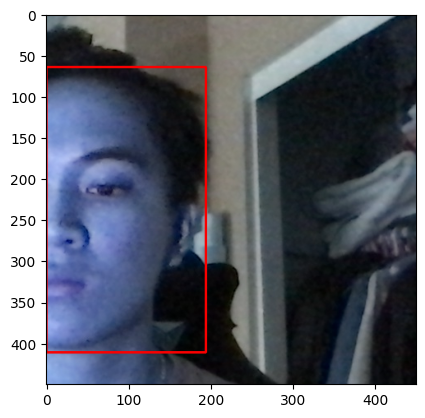

In [25]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)), #Gets the first two coordinates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), #Gets the last two coordinates
                    (250,0,0), 2)
plt.imshow(augmented['image'])

Running the Augmentation Pipeline


In [ ]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images', image)):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1] 
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug+data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation,f)


    

            